<a href="https://colab.research.google.com/github/RoseSarlake/Computer-Vision/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [200]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import cv2
import math
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import glob

In [5]:
# need a opencv version which has SIFT and SURF
# pip uninstall opencv-python
# pip install opencv-contrib-python==4.4.0.40
# pip install opencv-python==3.4.2.17 opencv-contrib-python==3.4.2.17
cv2.__version__

'4.4.0'

In [6]:
!python --version

Python 3.7.10


Some useful function from assignment 1

In [7]:
def My_Gaussian(size,sigma):
  w = size 
  hw = (w-1)/2
  sum = 0
  g = np.zeros(w)
  for i in range(0,w):
    # The continuous normalization factor can be ignored since it disappears in the discrete normalization step
    g[i] = math.exp(-((i-hw)*(i-hw))/(2*sigma*sigma))
    sum += g[i]
  for i in range(0,w):
    g[i] /= sum
  return g

In [8]:
def My_convolve2D(image, kernel, padding=0):
    # Cross Correlation
    kernel = np.flipud(np.fliplr(kernel))

    xKernShape = kernel.shape[0]
    yKernShape = kernel.shape[1]
    xImgShape = image.shape[0]
    yImgShape = image.shape[1]

    # Shape of Output Convolution
    xOutput = int((xImgShape - xKernShape + 2 * padding) + 1)
    yOutput = int((yImgShape - yKernShape + 2 * padding) + 1)
    output = np.zeros((xOutput, yOutput))

    # Apply mirror padding
    if padding != 0:
        imagePadded = cv2.copyMakeBorder(image,padding,padding,padding,padding,cv2.BORDER_REFLECT)
        #print(imagePadded)
    else:
        imagePadded = image

    # Convolution
    for y in range(image.shape[1]):
        for x in range(image.shape[0]):
          output[x, y] = (kernel * imagePadded[x:x+xKernShape,y:y+yKernShape]).sum()
    return output

In [9]:
def My_sampling(img,n,way):
  #re_img = cv2.resize(img,(img2a.shape[1],img2a.shape[0]),fx=2**n,fy=2**n,interpolation = cv2.INTER_CUBIC)
  if way == "up":
    re_img = cv2.resize(img,None,fx=2**n,fy=2**n,interpolation = cv2.INTER_CUBIC)
  if way == "down":
    re_img = cv2.resize(img,None,fx=1/2**n,fy=1/2**n,interpolation = cv2.INTER_CUBIC)
  return re_img

In [10]:
def My_pyrm(img,time,way):
  imgset = [img]
  sigma = 1
  for i in range(0,time):

    new = My_sampling(img,i+1,way)

    col = My_Gaussian(5,sigma)
    row = col.reshape(col.shape[0],1)
    ker = col*row
    conimg = My_convolve2D(new,ker,padding=2)
    
    imgset.append(conimg)
  return imgset

In [11]:
def My_Lappyr(img,layer):
  # Create a Gaussian Pyramid
  my_g_pyr = My_pyrm(img,layer,"down")
  # Create a Laplacian Pyramid
  laplacian_pyr = [my_g_pyr[-1]]
  for i in range(layer,0,-1):
    expand = My_pyrm(my_g_pyr[i],1,"up")
    laplacian = my_g_pyr[i-1] - expand[1]
    laplacian_pyr.append(laplacian)
  return laplacian_pyr,expand

# pre-process image mosaic 

In [12]:
# locate to images path
path = glob.glob("/content/drive/MyDrive/Colab Notebooks/image/*.jpg")
# store images in a list
images = [cv2.imread(file) for file in path]
len(images)
# create a grayscale version to detect more accurate
grayimg = images.copy()
for i in range(len(grayimg)):
  grayimg[i] = cv2.cvtColor(grayimg[i], cv2.COLOR_BGR2GRAY)

In [13]:
images[0].shape

(240, 320, 3)

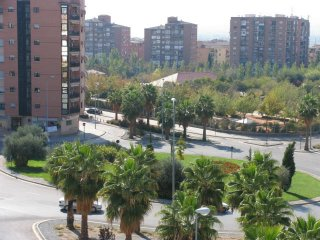

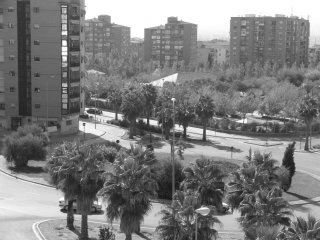

In [14]:
cv2_imshow(images[0])
cv2_imshow(grayimg[0])

# Extract features 

In [15]:
def MyFeature(inputlist):
  # keypoints and descriptions in each images
  kp = [None] * len(inputlist)
  des = [None] * len(inputlist)
  # create SIFT object
  sift = cv2.SIFT_create()

  for i in range(len(inputlist)):
    # detect and compute the key points
    kp[i], des[i] = sift.detectAndCompute(inputlist[i],None)
  return kp,des

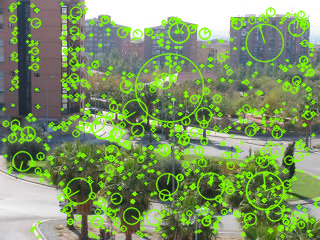

In [16]:
# detect and compute the feature of all the image set
mypoints, mydes = MyFeature(grayimg)
# draw the keypoints
cv2_imshow(cv2.drawKeypoints(images[0],mypoints[0],None,(0,255,128),flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))

# Match features


In [17]:
def MyMatching(des):
  # create a BFMatcher object
  bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
  # the list to store matching points
  matches = [None] * (len(des)-1)

  # -try knn
  # bf = cv2.BFMatcher()
  # for i in range(len(des)-1):
  #   # store the matching points, the length is 1 less than description list
  #   matches[i] = bf.knnMatch(des[i],des[i+1],k=2)
  #   good = []
  #   for m,n in matches[i]:
  #       if m.distance < 0.75*n.distance:
  #           good.append([m])
  #   matches.append(good)

  # find matching points
  for i in range(len(des)-1):
    # find matching points
    matches[i] = bf.match(des[i],des[i+1])
    #matches[i] = bf.knnMatch(des[i],des[i+1],k=3)
    # sort the keypoint by the distance
    matches[i] = sorted(matches[i], key = lambda x:x.distance)
  return matches

In [18]:
# FLANN method
# # FLANN parameters
# FLANN_INDEX_KDTREE = 1
# index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
# search_params = dict(checks=50)
# flann = cv2.FlannBasedMatcher(index_params,search_params)
# matches = flann.knnMatch(mydes[0],mydes[1],k=2)
# # Need to draw only good matches, so create a mask
# matchesMask =  [[0,0] for i in range(len(matches))]
# # ratio test as per Lowe's paper
# for i,(m,n) in enumerate(matches):
#   if m.distance < 0.7*n.distance:
#     matchesMask[i]=[1,0]
# draw_params = dict(matchColor = (0,255,0),
#                    singlePointColor = (255,0,0),
#                    matchesMask = matchesMask,
#                    flags = cv2.DrawMatchesFlags_DEFAULT)
# img3 = cv2.drawMatchesKnn(images[0],mypoints[0],images[1],mypoints[1],matches,None,**draw_params)
# cv2_imshow(img3)

9


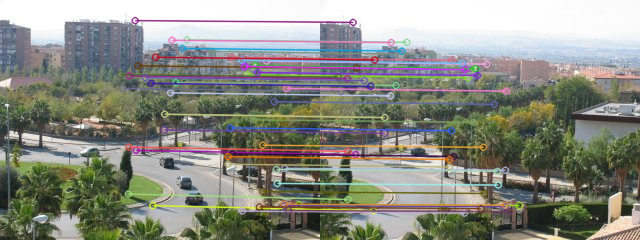

In [19]:
# compute all the matching pairs between every two neighboring images
mymatches = MyMatching(mydes)
print(len(mymatches))
# show one matching result, show the most strong 50 pairs
matching = cv2.drawMatches(images[4],mypoints[4],images[5],mypoints[5],mymatches[4][:50],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
#matched = cv2.drawMatchesKnn(images[4],mypoints[4],images[5],mypoints[5],mymatches[4][:50],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
cv2_imshow(matching)


# Compute a homography using RANSAC

In [20]:
def MyPairs(matches,kps):
  # two list to store each matching matrix
  left = []
  right = []
  # store the mathcing points into left and right matrix
  for i in range(len(matches)):
    # two matrix to store matching point information 
    p_left = np.zeros((len(matches[i]), 2))
    p_right = np.zeros((len(matches[i]), 2))
    # locate every matching points
    for j in range(len(matches[i])):
      p_left[j,:] = kps[i][matches[i][j].queryIdx].pt
      p_right[j,:] = kps[i+1][matches[i][j].trainIdx].pt
    # add to the prepared list
    left.append (p_left)
    right.append (p_right)
  return left,right


In [21]:
# store all the locations for every pairs in every two adjacent images
myleft,myright = MyPairs(mymatches,mypoints)
# check the length
print(len(myleft[5]))
print(len(myright[5]))

428
428


In [22]:
def MyHomography(obj,scene):
  # generate the homography list and mask list
  H = [None] * len(obj)
  mask = [None] * len(obj)
  # compute the homagrapgy using RANSAC
  for i in range(len(obj)):
    H[i], mask[i] = cv2.findHomography(obj[i], scene[i], cv2.RANSAC,1.0)
  return H,mask

In [23]:
myhomo, mymask = MyHomography(myright,myleft)
print(myhomo[6])

[[ 9.28225256e-01 -7.88620980e-03  9.34830165e+01]
 [-1.70451170e-02  9.75543395e-01 -5.81173926e-01]
 [-2.10384958e-04  9.96152305e-06  1.00000000e+00]]


In [66]:
# np.multiply and np.matmul is different
print(np.multiply(myhomo[0],myhomo[1]))
print(np.matmul(myhomo[0],myhomo[1]))

[[9.01352876e-01 5.01771983e-05 4.37038734e+03]
 [1.26785274e-04 9.60900660e-01 1.16937289e-01]
 [2.12715358e-08 1.23956522e-11 1.00000000e+00]]
[[ 8.91828268e-01 -1.34155740e-02  1.29123537e+02]
 [-2.18271891e-02  9.60988991e-01 -1.54433408e+00]
 [-2.84974915e-04  8.07826191e-06  9.90310124e-01]]


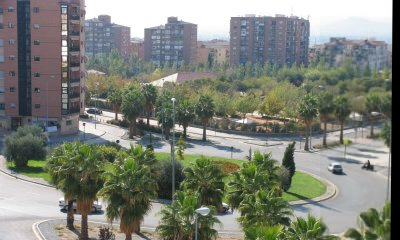

In [87]:
# try to stitch two images
warpimg = cv2.warpPerspective(images[1], myhomo[0],(400, 240))
warpimg[0:images[0].shape[0], 0:images[0].shape[1]] =images[0]
cv2_imshow(warpimg)

# Align images

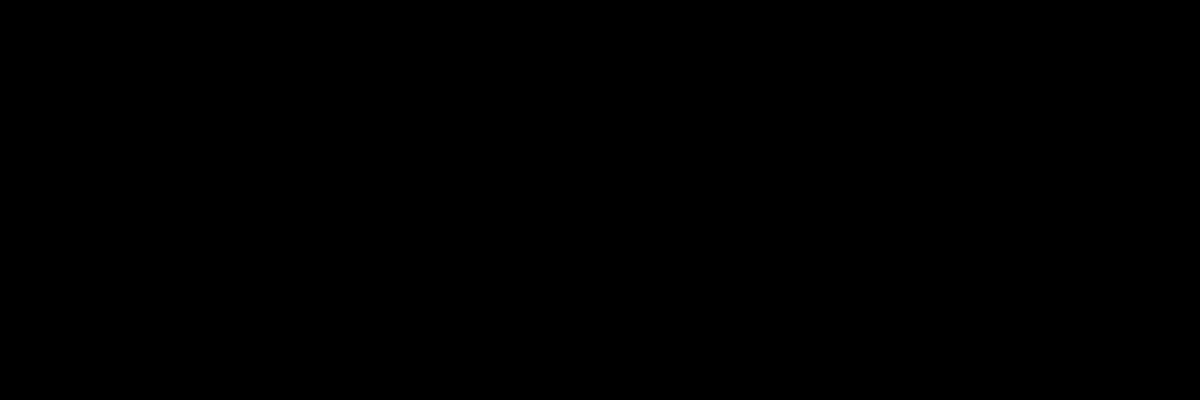

In [93]:
# create a big enough canvas
canvas = np.zeros((400, 1200, 3),np.uint8)
cv2_imshow(canvas)

(240, 320, 3)


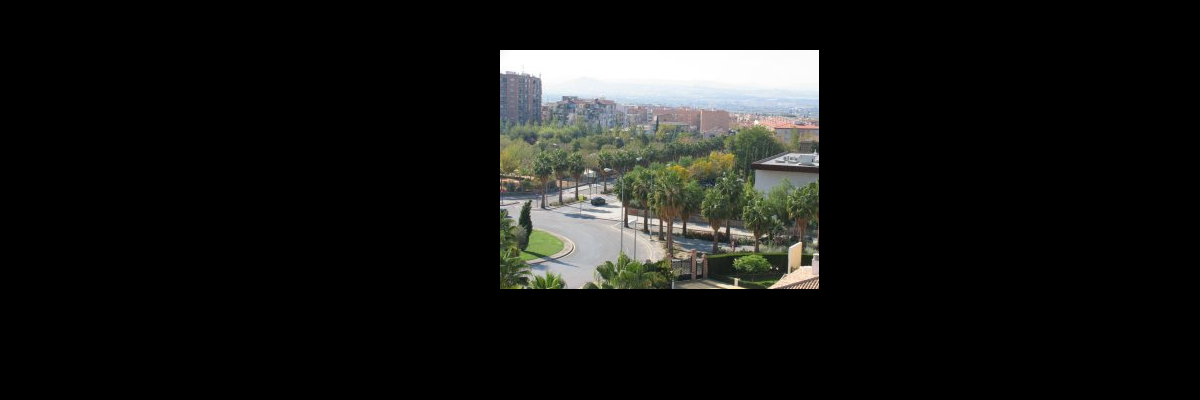

[[  1.   0. 500.]
 [  0.   1.  50.]
 [  0.   0.   1.]]


In [94]:
# put middle in the center
# middle image size
print(images[5].shape)
# define the 4 corner points of the original and the location in canvas
pts1 = np.array([[0,0],[320,0],[0,240],[320,240]])
pts2 = np.array([[500,50],[820,50],[500,290],[820,290]])
# find the homography between the middle image and canvas, here is a translation
h, status = cv2.findHomography(pts1, pts2, cv2.RANSAC,1.0)
# move the middle image to canvas
temp = cv2.warpPerspective(images[5], h, (canvas.shape[1],canvas.shape[0]),borderMode=cv2.BORDER_TRANSPARENT) 
cv2_imshow(temp)
print(h)

In [95]:
def Mynewhomo(homopre,homonow):
  # claculate the new homography
  newhomo = np.matmul(homopre,homonow)
  return newhomo

In [96]:
# the image in the left need to inverse
newhomo4 = Mynewhomo(h,np.linalg.inv(myhomo[4]))
newhomo3 = Mynewhomo(newhomo4,np.linalg.inv(myhomo[3]))
newhomo2 = Mynewhomo(newhomo3,np.linalg.inv(myhomo[2]))
newhomo1 = Mynewhomo(newhomo2,np.linalg.inv(myhomo[1]))
newhomo0 = Mynewhomo(newhomo1,np.linalg.inv(myhomo[0]))
# the image in the right
newhomo5 = Mynewhomo(h,myhomo[5])
newhomo6 = Mynewhomo(newhomo5,myhomo[6])
newhomo7 = Mynewhomo(newhomo6,myhomo[7])
newhomo8 = Mynewhomo(newhomo7,myhomo[8])

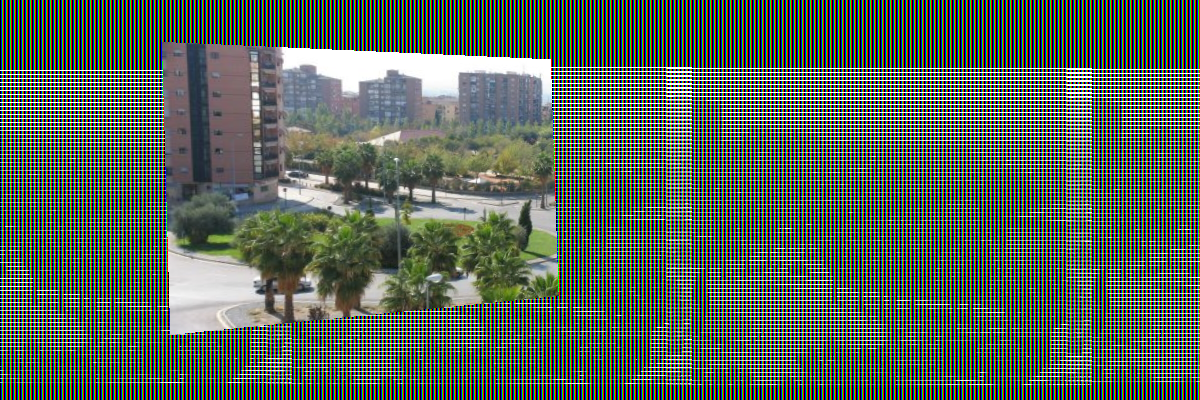

In [92]:
panorama= cv2.warpPerspective(images[0], newhomo0,(canvas.shape[1],canvas.shape[0]),borderMode=cv2.BORDER_TRANSPARENT)
cv2_imshow(panorama)

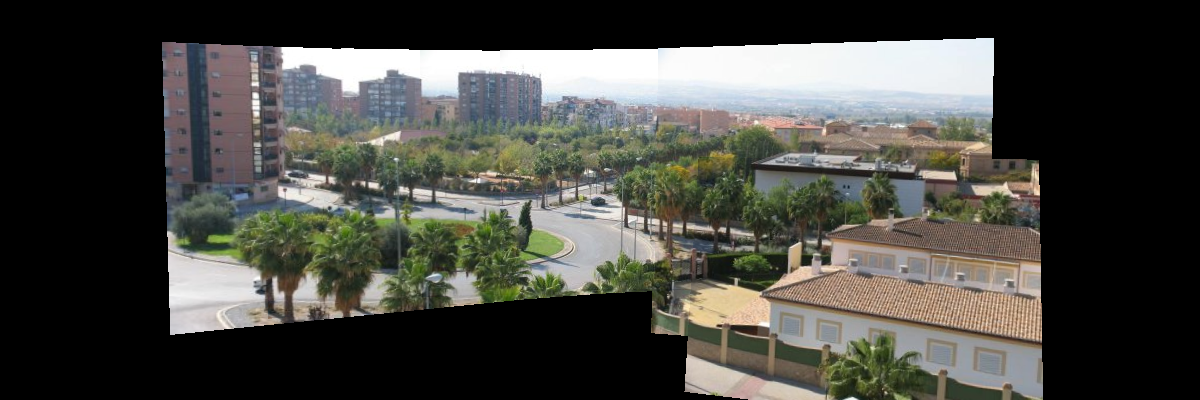

In [100]:
# stitch every images in the canvas
panorama = cv2.warpPerspective(images[0], newhomo0,(canvas.shape[1],canvas.shape[0]),borderMode=cv2.BORDER_TRANSPARENT)
panorama = cv2.warpPerspective(images[1], newhomo1,(canvas.shape[1],canvas.shape[0]),borderMode=cv2.BORDER_TRANSPARENT)
panorama = cv2.warpPerspective(images[2], newhomo2,(canvas.shape[1],canvas.shape[0]),borderMode=cv2.BORDER_TRANSPARENT)
panorama = cv2.warpPerspective(images[3], newhomo3,(canvas.shape[1],canvas.shape[0]),borderMode=cv2.BORDER_TRANSPARENT)
panorama = cv2.warpPerspective(images[4], newhomo4,(canvas.shape[1],canvas.shape[0]),borderMode=cv2.BORDER_TRANSPARENT)
panorama = cv2.warpPerspective(images[5], h, (canvas.shape[1],canvas.shape[0]),borderMode=cv2.BORDER_TRANSPARENT) 
panorama = cv2.warpPerspective(images[6], newhomo5,(canvas.shape[1],canvas.shape[0]),borderMode=cv2.BORDER_TRANSPARENT)
panorama = cv2.warpPerspective(images[7], newhomo6,(canvas.shape[1],canvas.shape[0]),borderMode=cv2.BORDER_TRANSPARENT)
panorama = cv2.warpPerspective(images[8], newhomo7,(canvas.shape[1],canvas.shape[0]),borderMode=cv2.BORDER_TRANSPARENT)
panorama = cv2.warpPerspective(images[9], newhomo8,(canvas.shape[1],canvas.shape[0]),borderMode=cv2.BORDER_TRANSPARENT)
# show the final panorama
cv2_imshow(panorama)

# Color mixing

In [120]:
def Myblending(img,mask,levels):
  # copy the image and mask to the working place
  img_gau = img.copy()
  mask_gau = mask.copy()

  # genetare Gaussian pyramid image and mask
  img_gaupyr = [img_gau]
  mask_gaupyr = [mask_gau]

  for i in range(levels):
    img_gau = cv2.pyrDown(img_gau)
    mask_gau = cv2.pyrDown(mask_gau)
    # push in pyramid
    img_gaupyr.append(np.float32(img_gau))
    mask_gaupyr.append(np.float32(mask_gau))

  # create the Laplacian pyramids for image and masks
  img_lappyr = [img_gaupyr[levels-1]]
  mask_lappyr = [mask_gaupyr[levels-1]]
  # from top to down
  for i in range(levels-1,0,-1):
    img_lap = np.subtract(img_gaupyr[i-1],cv2.pyrUp(img_gaupyr[i]))
    # push in pyramid
    img_lappyr.append(img_lap)
    mask_lappyr.append(mask_gaupyr[i-1])
    
  # blending mask 
  blends = []
  for bimg,bmask in zip(img_lappyr,mask_lappyr):
    blend = bimg * bmask 
    blends.append(blend)
  # reconstruct
  cons = blends[0]
  for i in range(1,levels):
    cons = cv2.pyrUp(cons)
    cons = cv2.add(cons,blends[i])
  return cons

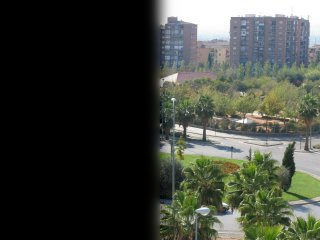

In [137]:
# try to use half-white-half-black mask
m = np.zeros_like(images[0], dtype='float32')
m [:,images[0].shape[1]//2:] = 1
recon = Myblending(images[0],m,4)
cv2_imshow(recon)

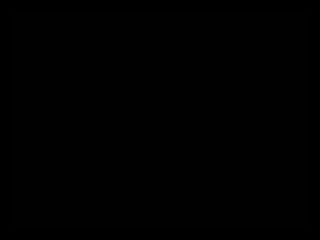

In [182]:
# genetate the edge blue mask
mymask = np.zeros((240,320,3), np.uint8)
mymask[10:230,10:310]= 1
#mymask[10:230,10:310] = 1
#mymask[10:230,10:310] = (255,255,255)
cv2_imshow(mymask)

In [196]:
# pass all image to the edge blur function
images_bl = []
#images_trans = []
for i in range(0,len(images)):
  #img_rgba = cv2.cvtColor(images[i],cv2.COLOR_RGB2RGBA)
  img_bl = Myblending(images[i],mymask,4)
  #tmp = cv2.cvtColor(img_bl, cv2.COLOR_BGR2GRAY)
  #_,alpha = cv2.threshold(tmp,0,255,cv2.THRESH_BINARY)
  #b, g, r = cv2.split(images[i])
  #rgba = [b,g,r,alpha]
  #dst = cv2.merge(rgba,4)
  #source.convertTo(OriginalFloat, CV_32FC1, 1.0/255.0)
  #cv2.imwrite("test.png", dst)
  images_bl.append(img_bl)


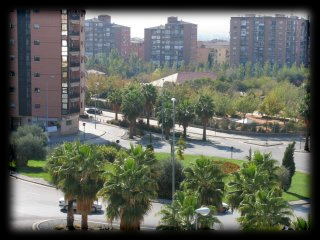

In [197]:
cv2_imshow(images_bl[0])

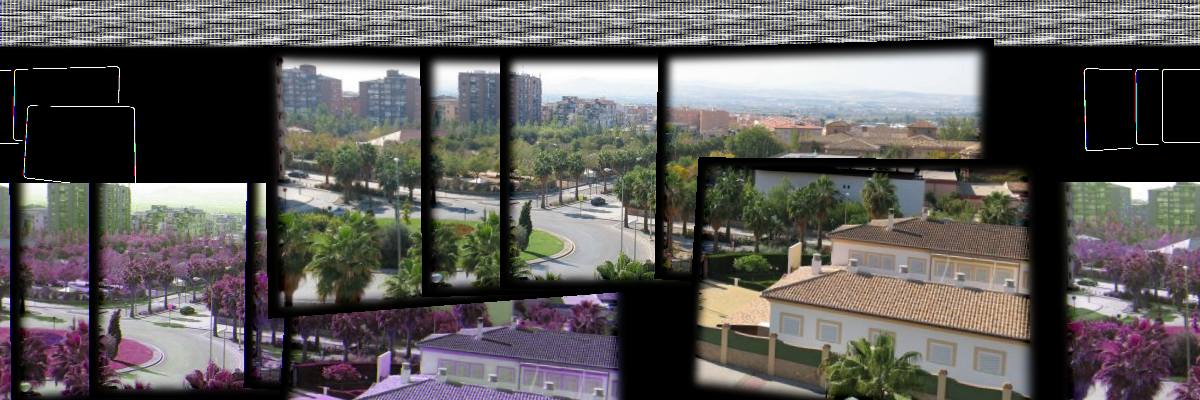

In [199]:
# new panorama
canvas = np.zeros((400, 1200, 3),np.uint8)
# put new mosaics
panorama_update = cv2.warpPerspective(images_bl[0], newhomo0,(canvas.shape[1],canvas.shape[0]),borderMode=cv2.BORDER_TRANSPARENT)
panorama_update = cv2.warpPerspective(images_bl[1], newhomo1,(canvas.shape[1],canvas.shape[0]),borderMode=cv2.BORDER_TRANSPARENT)
panorama_update = cv2.warpPerspective(images_bl[2], newhomo2,(canvas.shape[1],canvas.shape[0]),borderMode=cv2.BORDER_TRANSPARENT)
panorama_update = cv2.warpPerspective(images_bl[3], newhomo3,(canvas.shape[1],canvas.shape[0]),borderMode=cv2.BORDER_TRANSPARENT)
panorama_update = cv2.warpPerspective(images_bl[4], newhomo4,(canvas.shape[1],canvas.shape[0]),borderMode=cv2.BORDER_TRANSPARENT)
panorama_update = cv2.warpPerspective(images_bl[5], h, (canvas.shape[1],canvas.shape[0]),borderMode=cv2.BORDER_TRANSPARENT) 
panorama_update = cv2.warpPerspective(images_bl[6], newhomo5,(canvas.shape[1],canvas.shape[0]),borderMode=cv2.BORDER_TRANSPARENT)
panorama_update = cv2.warpPerspective(images_bl[7], newhomo6,(canvas.shape[1],canvas.shape[0]),borderMode=cv2.BORDER_TRANSPARENT)
panorama_update = cv2.warpPerspective(images_bl[8], newhomo7,(canvas.shape[1],canvas.shape[0]),borderMode=cv2.BORDER_TRANSPARENT)
panorama_update = cv2.warpPerspective(images_bl[9], newhomo8,(canvas.shape[1],canvas.shape[0]),borderMode=cv2.BORDER_TRANSPARENT)
# show the final panorama
cv2_imshow(panorama_update)